# Step 1: Data processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/archive.zip'

extract_to_path = '/content/traffic_light'

os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"zip to: {extract_to_path}")

zip to: /content/traffic_light


In [11]:
import os
import json
import shutil
import cv2
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

In [ ]:
def split_dataset(json_file, images_dir, output_dir, split_ratios=(0.7, 0.15, 0.15)):
    with open(json_file, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']

    os.makedirs(output_dir, exist_ok=True)
    split_dirs = {
        "train": os.path.join(output_dir, "train"),
        "val": os.path.join(output_dir, "val"),
        "test": os.path.join(output_dir, "test"),
    }

    for split in split_dirs.values():
        os.makedirs(os.path.join(split, "images"), exist_ok=True)
        os.makedirs(os.path.join(split, "labels"), exist_ok=True)

    grouped_annotations = {}
    for annotation in annotations:
        filename = annotation['filename'].replace("\\", "/")
        grouped_annotations.setdefault(filename, []).append(annotation)

    filenames = list(grouped_annotations.keys())
    train_files, temp_files = train_test_split(filenames, test_size=(1 - split_ratios[0]), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]), random_state=42)
    splits = {"train": train_files, "val": val_files, "test": test_files}

    def process_file(filename, annotations, split_dir):
        img_name = os.path.basename(filename)
        label_name = os.path.splitext(img_name)[0] + ".txt"

        src_image = os.path.join(images_dir, filename)
        dst_image = os.path.join(split_dir, "images", img_name)
        if not os.path.exists(src_image):
            print(f"Warning: {src_image} does not exist.")
            return

        shutil.copyfile(src_image, dst_image)

        img = cv2.imread(src_image)
        if img is None:
            print(f"Warning: Could not read {src_image}. Skipping.")
            return
        img_height, img_width = img.shape[:2]

        label_path = os.path.join(split_dir, "labels", label_name)
        with open(label_path, 'w') as f:
            for annotation in annotations:
                bbox = annotation['bndbox']
                color = annotation['inbox'][0]['color'] if annotation['inbox'] else 'red'
                class_id = 0 if color == 'red' else 1

                xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
                xmin, xmax = max(0, xmin), min(img_width - 1, xmax)
                ymin, ymax = max(0, ymin), min(img_height - 1, ymax)

                x_center = (xmin + xmax) / 2 / img_width
                y_center = (ymin + ymax) / 2 / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width <= 1 and 0 <= height <= 1:
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    def save_split(files, split_name):
        split_dir = split_dirs[split_name]
        with ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(process_file, filename, grouped_annotations[filename], split_dir)
                for filename in files
            ]
            for future in futures:
                future.result()

    for split_name, files in splits.items():
        save_split(files, split_name)

json_file = '/content/traffic_light/train_dataset/train.json'
images_dir = '/content/traffic_light/train_dataset'
output_dir = 'yolo_dataset'
split_dataset(json_file, images_dir, output_dir)


Genrating yaml file

In [ ]:
data_yaml_content = """
train: yolo_dataset/train/images
val: yolo_dataset/val/images
test: yolo_dataset/test/images

nc: 2  # Number of classes (red, green)
names: ['red', 'green']  # Class names
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)


# Step 2: Training

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')
model.train(data="/content/data.yaml", epochs=15, batch=16, imgsz=640)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 156MB/s]


Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

train: Scanning /content/yolo_dataset/train/labels... 1819 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1819/1819 [00:01<00:00, 1449.31it/s]

train: New cache created: /content/yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo_dataset/val/labels... 390 images, 0 backgrounds, 0 corrupt: 100%|██████████| 390/390 [00:00<00:00, 1535.20it/s]

val: New cache created: /content/yolo_dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G      1.812      2.547     0.9416        149        640: 100%|██████████| 114/114 [1:19:27<00:00, 41.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:18<00:00, 15.26s/it]

                   all        390       2242      0.464      0.297      0.274      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G      1.861       1.46      0.937         83        640: 100%|██████████| 114/114 [1:19:09<00:00, 41.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:15<00:00, 15.02s/it]

                   all        390       2242       0.63      0.329      0.364      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G      1.873      1.418     0.9466         91        640: 100%|██████████| 114/114 [1:18:45<00:00, 41.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:14<00:00, 14.95s/it]

                   all        390       2242      0.567      0.334      0.342      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G      1.826      1.331     0.9431        109        640: 100%|██████████| 114/114 [1:17:51<00:00, 40.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:16<00:00, 15.14s/it]

                   all        390       2242      0.625      0.354      0.386      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G      1.743      1.214      0.918         72        640: 100%|██████████| 114/114 [1:18:51<00:00, 41.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:14<00:00, 14.96s/it]

                   all        390       2242      0.645      0.357      0.399       0.19


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G      1.756      1.242     0.9239         72        640: 100%|██████████| 114/114 [1:19:01<00:00, 41.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:15<00:00, 15.06s/it]

                   all        390       2242      0.591      0.363      0.381      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15         0G       1.77      1.222      0.895         60        640:   7%|▋         | 8/114 [05:38<1:14:20, 42.08s/it]

Step 3: Evaluation

In [ ]:
# Perform inference on test images
results = model.predict(source='yolo_dataset/test/images', save=True, conf=0.5)

# Display results
for result in results:
    print(result)


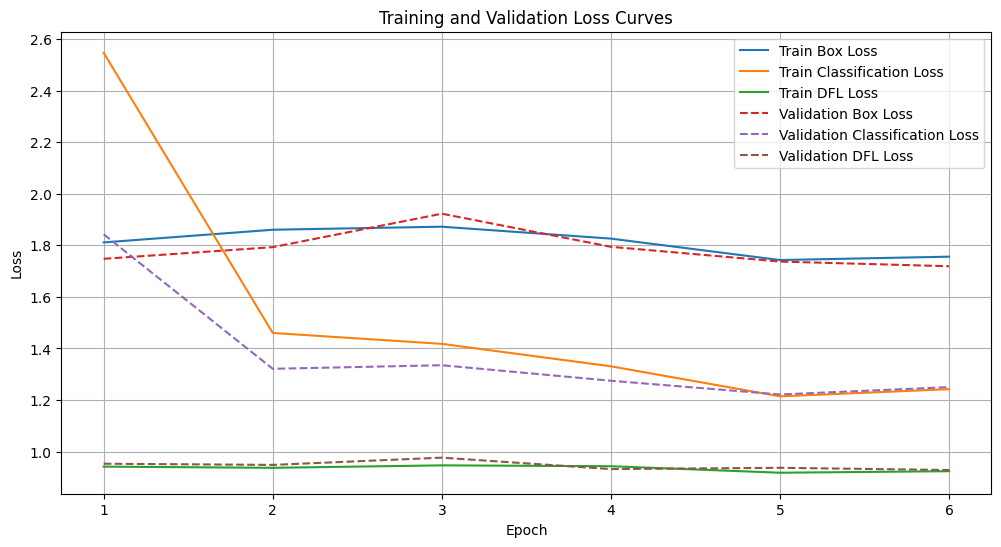

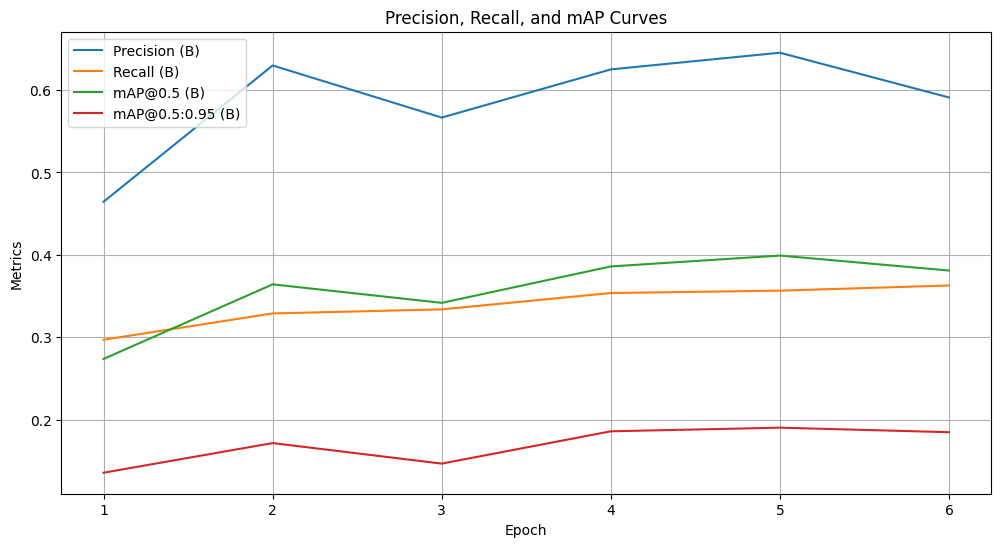

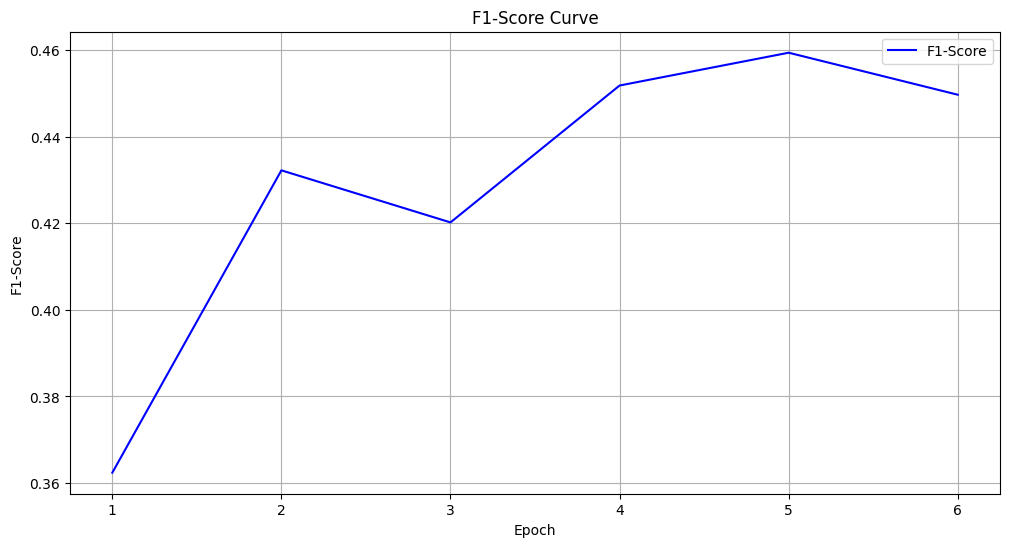

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


results_file = "/content/runs/detect/train/results.csv"
data = pd.read_csv(results_file)


data['F1-Score'] = 2 * (data['metrics/precision(B)'] * data['metrics/recall(B)']) / (
    data['metrics/precision(B)'] + data['metrics/recall(B)']
)


plt.figure(figsize=(12, 6))
plt.plot(data['epoch'], data['train/box_loss'], label='Train Box Loss')
plt.plot(data['epoch'], data['train/cls_loss'], label='Train Classification Loss')
plt.plot(data['epoch'], data['train/dfl_loss'], label='Train DFL Loss')
plt.plot(data['epoch'], data['val/box_loss'], label='Validation Box Loss', linestyle='--')
plt.plot(data['epoch'], data['val/cls_loss'], label='Validation Classification Loss', linestyle='--')
plt.plot(data['epoch'], data['val/dfl_loss'], label='Validation DFL Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(data['epoch'], data['metrics/precision(B)'], label='Precision (B)')
plt.plot(data['epoch'], data['metrics/recall(B)'], label='Recall (B)')
plt.plot(data['epoch'], data['metrics/mAP50(B)'], label='mAP@0.5 (B)')
plt.plot(data['epoch'], data['metrics/mAP50-95(B)'], label='mAP@0.5:0.95 (B)')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and mAP Curves')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(data['epoch'], data['F1-Score'], label='F1-Score', color='blue')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score Curve')
plt.legend()
plt.grid(True)
plt.show()


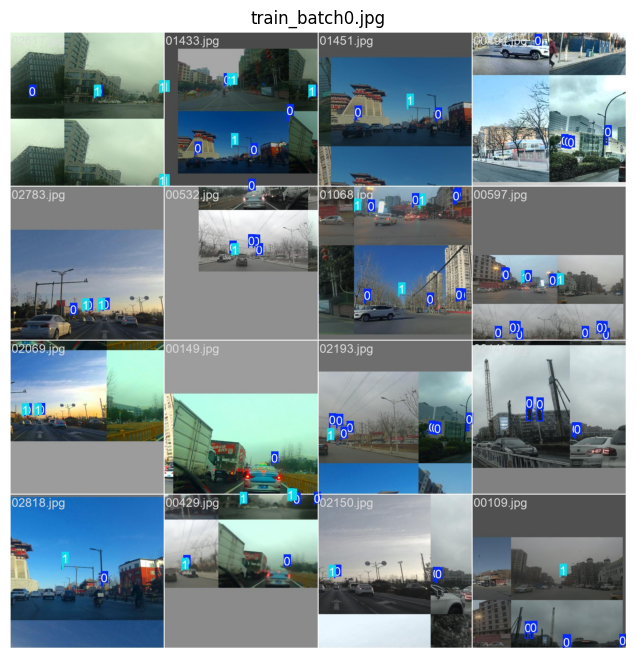

In [12]:
def display_image(image_path):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

train_batch_path = "/content/runs/detect/train/train_batch0.jpg"
display_image(train_batch_path)


image 1/1 /content/yolo_dataset/train/images/01065.jpg: 384x640 2 reds, 1 green, 386.0ms
Speed: 3.0ms preprocess, 386.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


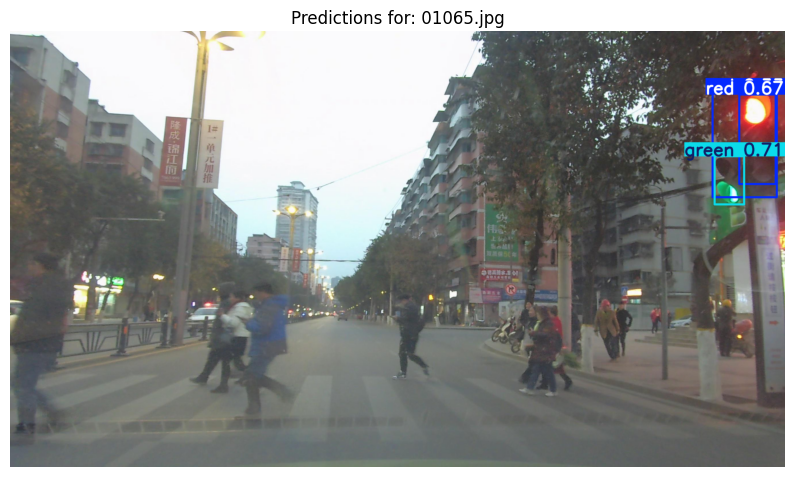


image 1/1 /content/yolo_dataset/train/images/00547.jpg: 384x640 7 reds, 436.1ms
Speed: 4.4ms preprocess, 436.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


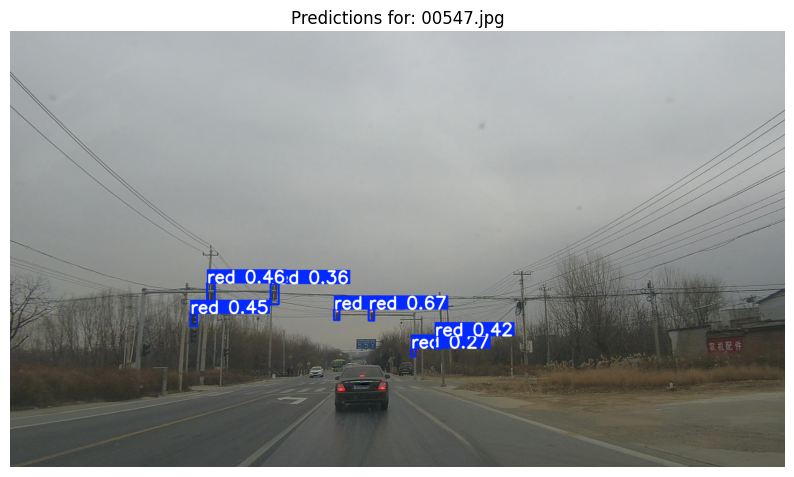


image 1/1 /content/yolo_dataset/train/images/02522.jpg: 384x640 1 red, 459.3ms
Speed: 4.3ms preprocess, 459.3ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)


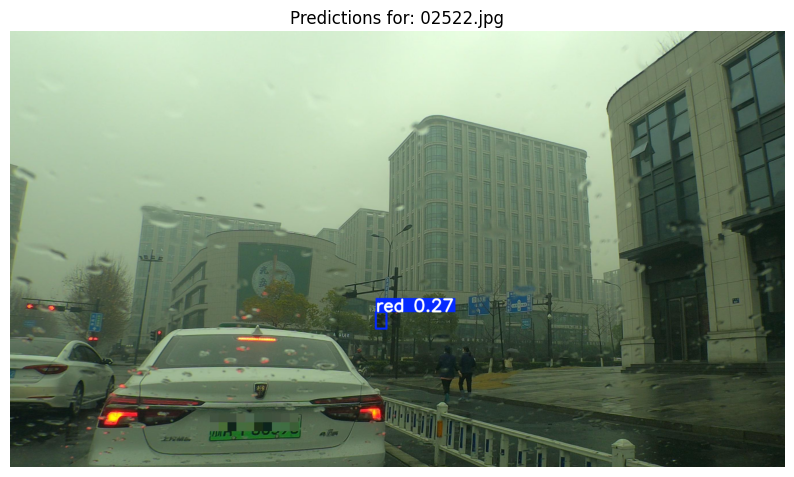


image 1/1 /content/yolo_dataset/train/images/02878.jpg: 384x640 1 red, 3 greens, 457.7ms
Speed: 4.3ms preprocess, 457.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


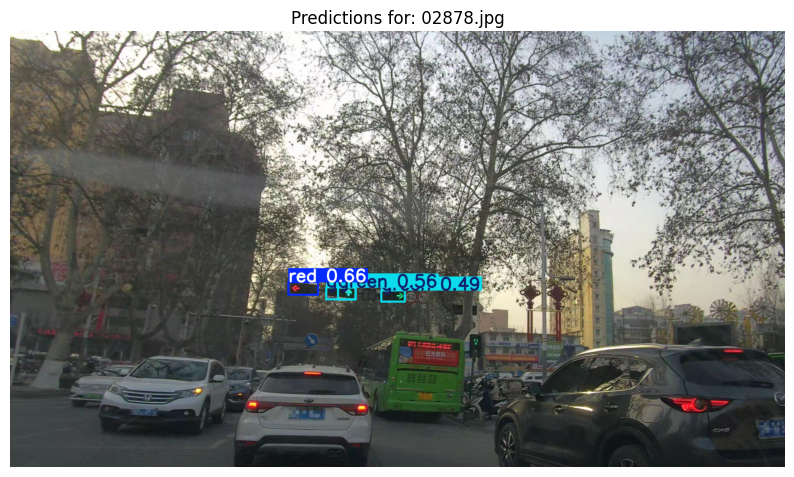


image 1/1 /content/yolo_dataset/train/images/01204.jpg: 384x640 1 green, 627.5ms
Speed: 4.9ms preprocess, 627.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


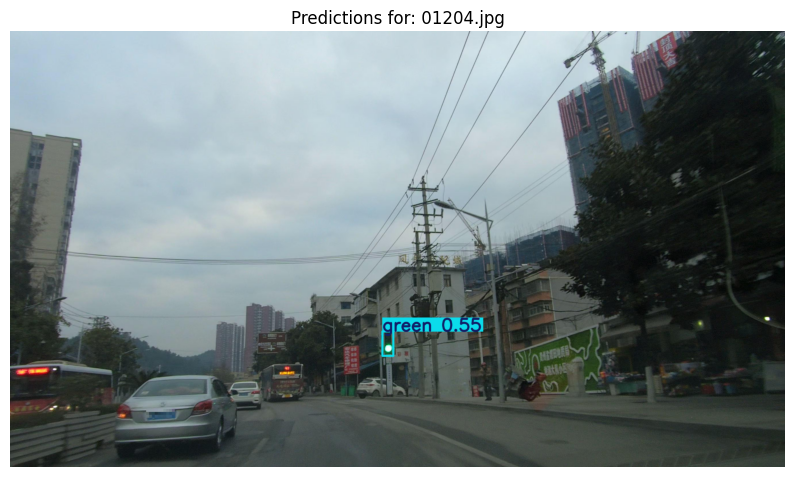

In [14]:
import random
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os


model_path = "/content/runs/detect/train/weights/best.pt"
test_images_dir = "/content/yolo_dataset/train/images"


model = YOLO(model_path)


image_files = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]


random_images = random.sample(image_files, min(len(image_files), 5))

for image_path in random_images:
    results = model.predict(source=image_path, save=False, conf=0.25)


    for result in results:

        annotated_frame = result.plot()

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Predictions for: {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()
